# Innate Binocular Visual Learning Project
### Final Project for COMP 386: Computational Neuroscience
#### Worked on by:
- Sam Sendelbach
- David Saffo
- Mary Makarious

#### Project Summary
[Copy paste]

---

##### Necessary Packages to Import 

In [1]:
from numpy import *
import pylab
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.image as mpimg
from sklearn.decomposition import FastICA
from sklearn.feature_extraction import image
import PIL
%matplotlib inline

---

##### [Insert Description Here]

In [2]:
def distance(x0, y0, x1, y1):
  return sqrt(pow(x0-x1,2) + pow(y0-y1,2))

class LGN: 
  """
  this class defines a model which generates binocular spontaneous activity
  """
  
  def __init__(self, width = 128, p = 0.5, r = 1.0, t = 1, trans = 0.0,
    make_wave = True, num_layers=2, random_seed=0):
    random.seed(random_seed)
    self.width = width
    self.p = p
    self.r = r
    self.t = t
    self.trans = trans
    self.num_layers = num_layers
    if make_wave:
      self.reset_wave()

  def reset_wave(self):
    """ create another random wave """
    # setting up the network
    w = self.width
    self.recruitable = random.rand(self.num_layers, w, w) < self.p
    self.tot_recruitable = len(where(self.recruitable)[0])
    self.tot_recruitable_active = 0
    self.tot_active = 0
    self.active = zeros([self.num_layers,w,w],bool)
    self.active_neighbors = zeros([self.num_layers,w,w],int)
    self.activated = []; # the recently active nodes
    
    if self.tot_recruitable > 0:
      while self.fraction_active() < 0.2:
        self.activate()  

  def fraction_active(self):
    """ returns the fraction of potentially recruitable cells which are active """
    if self.tot_recruitable > 0:
      return float(self.tot_recruitable_active) / self.tot_recruitable
    else:
      return nan

  def propagate(self):
    """ propagate the activity if a valid node has been activated """
    # activated only has recruitable and currently inactive members
    while len(self.activated) > 0:
      act_l, act_x, act_y = self.activated.pop()
      self.active[act_l,act_x,act_y] = True
      self.tot_active += 1
      self.tot_recruitable_active += 1
      for l in range(self.num_layers):
        for x in range(int(act_x-self.r),int(act_x+self.r+1)):
          for y in range(int(act_y-self.r),int(act_y+self.r+1)):
            if distance(act_x,act_y,x,y) <= self.r:
              xi = x % self.width
              yi = y % self.width
              if l != act_l: # spread the activity across layers
                if random.rand() < self.trans: # transfer the activity
                  self.active_neighbors[l, xi,yi] += 1
              else: # if it is the same layer
                self.active_neighbors[l, xi,yi] += 1
              if self.active_neighbors[l, xi,yi] == self.t and \
                not self.active[l, xi,yi]:
                if self.recruitable[l, xi,yi]:
                  self.activated.append([l, xi,yi])
                else: # activate the node but don't propagate the activity
                  self.active[l,xi,yi] = True
                  self.tot_active += 1

  def activate(self):
    """ activate a random potentially active node """
    if self.fraction_active() > 0.95:
      return
      
    # pick a random point
    while True:
      l = random.randint(0,self.num_layers)
      x = random.randint(0,self.width)
      y = random.randint(0,self.width)
      if (self.recruitable[l,x,y] and not self.active[l,x,y]):
        break
    self.activated.append([l,x,y])
    self.propagate()

  def correlation(self):
    """ returns the correlation between the left and right images """
    # the total number of activations in common
    # same_count = len(where(self.active[0,:,:] == self.active[1,:,:])[0])
    # return float(same_count) / (self.width * self.width)
    
    # create an activity matrix of 0's and 1's (instead of True and False)
    if self.num_layers < 2:
      print("monocular models cannot have correlations between eye layers")
      return 0
    w = self.width
    active01 = zeros([2,w,w],int)
    active01[where(self.active)] = 1
    
    mean0 = active01[0,:,:].mean()
    mean1 = active01[1,:,:].mean()
    std0 = active01[0,:,:].std()
    std1 = active01[1,:,:].std()
    cov = ((active01[0,:,:] - mean0) * (active01[1,:,:] - mean1)).mean()
    return cov / (std0 * std1)
    
    
  def make_img_mat(self, show_img=True):
    """ return a matrix of 1's and 0's showing the activity in both layers """
    img_array = zeros([self.num_layers,self.width,self.width])
    border_width = 10 if self.num_layers > 1 else 0
    w = self.width
    for l in range(self.num_layers):
        img = zeros([w, w], float)
        for x in range(0,w-1):
            for y in range(0,w-1):
                if self.active[l,x,y]:
                    img[x,y] = 1
                    
    
        img_array[l] = img 
        if show_img:
            plt.imshow(img)
            plt.show()
        
    return img_array


def linear_convolution(center, slide, plot=False): 
    if (center.shape != slide.shape):
        return
    padded_slide = np.zeros((center.shape[0],center.shape[1]*3))
    padded_slide[0:,center.shape[1]:center.shape[1]*2] = center
    estimate = np.empty([center.shape[1]*2])
    for x in range(center.shape[1]*2):
        dot = np.sum(padded_slide[0:,0+x:center.shape[1]+x] * slide)
        estimate[x] = dot
    
    if plot:
        plt.plot(np.abs(estimate))
        plt.show()
    #print(np.argmax(np.abs(estimate)))
    #print('{:.20f}'.format(np.mean(np.abs(estimate))))
    return np.mean(np.abs(estimate)),np.argmax(np.abs(estimate))


##### [Description Here]

#### Parameters 
- p = recrutable cells (cell spacing, chemical inhibition, recovery speed)
- r = similar to "dendritic field size" (radius)
- t = threshold (how many neighbors are are needed to activate)
- trans = probability of transmitting activity from one eye layer to the next (cross-talk between layers)

In [38]:
from random import randint
patches_1 = []
patches_2 = []

for n in range(30):
    seed = randint(1,100)
    L = LGN(width = 128, p = 0.2, r = 1.5, t = 1, trans = 0.2, make_wave = True, num_layers=2, random_seed=seed)
    images = L.make_img_mat(show_img=False)
    
    patch_size = 16


    patches_1.append(image.extract_patches_2d(images[0], (patch_size, patch_size)))
    patches_2.append(image.extract_patches_2d(images[1], (patch_size, patch_size)))
    
    #patches_1 = np.array(patches_1)
    #patches_2 = np.array(patches_2)

    
        
patches_1 = np.array(patches_1)
patches_2 = np.array(patches_2)

blacklist = []

for x in range(0,patches_1.shape[0]):
    if patches_1[x].std() == 0.0:
        blacklist.append(x)
        continue
            #add to black list
    
    if patches_2[x].std() == 0.0:
        blacklist.append(x)
        #add to black list

blacklist = np.array(blacklist)
if (blacklist.shape[0] != 0):
    patches_1 = np.delete(patches_1, blacklist, axis=0)
    patches_2 = np.delete(patches_2, blacklist, axis=0)
        #removes boring patches!
        
        
patches_1 = patches_1.reshape((patches_1.shape[0]*patches_1.shape[1]),patch_size,patch_size)
patches_2 = patches_2.reshape((patches_2.shape[0]*patches_2.shape[1]),patch_size,patch_size)

In [39]:
reshaped_patches_1 = patches_1.reshape(-1,patch_size**2)
reshaped_patches_2 = patches_2.reshape(-1,patch_size**2)
composite_patches = np.concatenate((reshaped_patches_1,reshaped_patches_2),axis=1)
n_ica_components = 50


icatemp = FastICA(n_components=n_ica_components, random_state=1) # note, sensitive to n_components
icafit_1 = icatemp.fit(composite_patches)
ica_comp_1 = icafit_1.components_

#icafit_2 = icatemp.fit(reshaped_patches_2)
#ica_comp_2 = icafit_2.components_


#np.array_equal(ica_comp_1,ica_comp_2)
ica_comp_1.shape


(50, 512)

In [40]:
first_eye = ica_comp_1[:,0:patch_size**2]
second_eye = ica_comp_1[:,patch_size**2:]

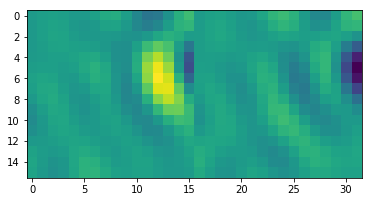

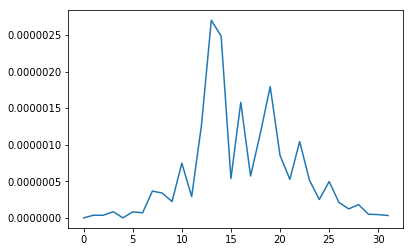

peak is at: 13.000000


In [41]:
results_1 = first_eye.reshape(-1,patch_size, patch_size)
results_2 = second_eye.reshape(-1,patch_size,patch_size)



sample = 30
composite_result = np.concatenate((results_1[sample],results_2[sample]),axis=1)


plt.imshow(composite_result)
plt.show()


mean, peak = linear_convolution(results_1[sample], results_2[sample],plot=True)
print("peak is at: %f" %peak)


In [42]:
long_sum = 0
num_disp = 0

for x in range(0,results_1.shape[0]):
    avg, maxi = linear_convolution(results_1[x], results_2[x])
    long_sum += abs(maxi - patch_size)
    if (abs(maxi - patch_size) != 0.0):
        num_disp = num_disp + 1
print(long_sum/results_1.shape[0])
print(num_disp)



1.1
21
